In [1]:
%run ../robustness_analysis.ipynb

## Define parametric environment

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

## Define deviation domain

In [3]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the initial states
x0_bounds = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

## Define system and controller

In [4]:
def env_builder(delta):
    return MutatedCartPoleEnv(masscart=delta[0], force_mag=delta[1]), x0_bounds

In [5]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

In [6]:
model = PID()

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.next_action(obs),

    # some agents (like PID) needs to be reset for each run
    'model_reset': lambda : model.reset()
}

## Define STL property

In [7]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def signal_builder(record, time_index):
    return {
        "pos": stl.Signal(
            normalize(np.abs(record[:, 0]), pos_range),
            time_index
        ),
        "angle": stl.Signal(
            normalize(np.abs(record[:, 2]), angle_range),
            time_index
        )
    }

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

## Define distance function

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')

## Start analysis

In [10]:
from datetime import datetime

In [11]:
def plot_convergence(analysis, Xss, out_dir='data'):
    for i in range(analysis.options['deviation_restarts']+1):
        analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction", out_dir=out_dir)
        plt.scatter(Xss[i][:, 0] * 24, Xss[i][:, 1] * 24, c=np.arange(len(Xss[i])), cmap='Greys')
        plt.show()

In [12]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['deviation_restarts'] = 2
analysis.options['deviation_sigma'] = 0.2
analysis.options['deviation_evals'] = 100
analysis.options['falsification_sigma'] = 0.4
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_restarts'] = 0
analysis.options

{'epsilon': 0.01,
 'deviation_restarts': 2,
 'deviation_sigma': 0.2,
 'deviation_timeout': inf,
 'deviation_evals': 100,
 'falsification_sigma': 0.4,
 'falsification_timeout': 1,
 'falsification_restarts': 0,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 200}

### Any deviation

In [ ]:
start = datetime.now()
delta, delta_dist = analysis.any_unsafe_deviation()
print('Time to find any unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
# analysis.visualize_deviation(delta, "gifs/any_counterexample.gif")

### Min deviation

In [13]:
start = datetime.now()
delta, delta_dist, Xss = analysis.min_unsafe_deviation()
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=863609, Tue Nov 29 09:30:47 2022)


/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


CMA Results:=================>
CMAEvolutionStrategyResult(xbest=array([0.07383983, 0.774755  ]), fbest=0.002878605478571271, evals_best=7, evaluations=102, iterations=17, xfavorite=array([0.63769757, 0.10125936]), stds=array([0.11605242, 0.10462849]), stop={'maxfevals': 100})
=============================>
{'x': array([0.68116045, 0.13429303]), 'f': 0.39778482014511873, 'g': [-0.250000009934107], 'f_al': 0.03785385934555846, 'g_al': [-0.3599309607995603], 'count': 101}

================ Min unsafe deviation trial 2 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=817843, Tue Nov 29 09:32:09 2022)
CMA Results:=================>
CMAEvolutionStrategyResult(xbest=array([0.03937626, 0.63085061]), fbest=0.0015084475078056313, evals_best=11, evaluations=102, iterations=17, xfavorite=array([0.53307779, 0.30861342]), stds=array([0.70735929, 0.23361205]), stop={'maxfevals': 100})
=============================>
{'x': array([0.52662535, 0.06243841]), 'f': 0.41463944604643627

In [14]:
# analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

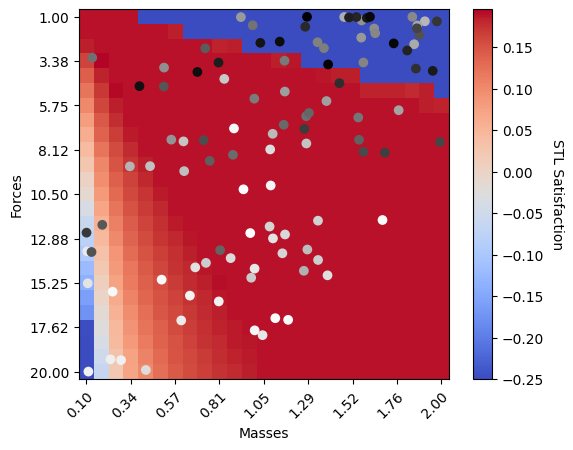

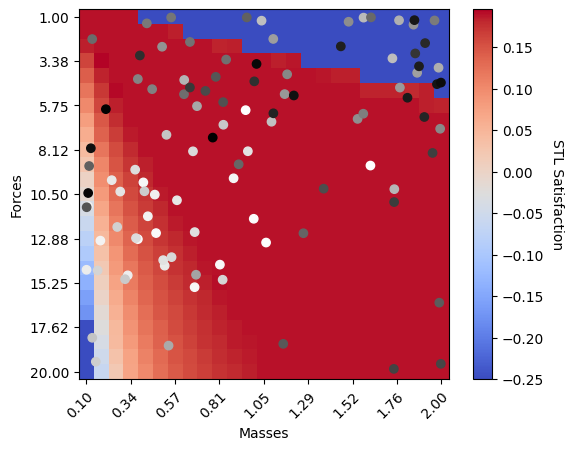

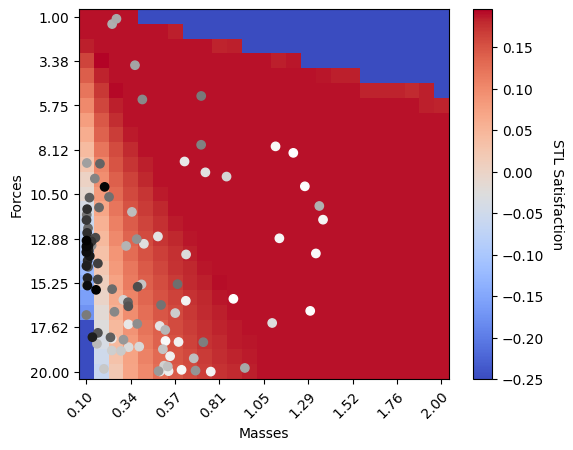

In [15]:
plot_convergence(analysis, Xss)

In [16]:
boundary = delta_dist

### Robustness landspace

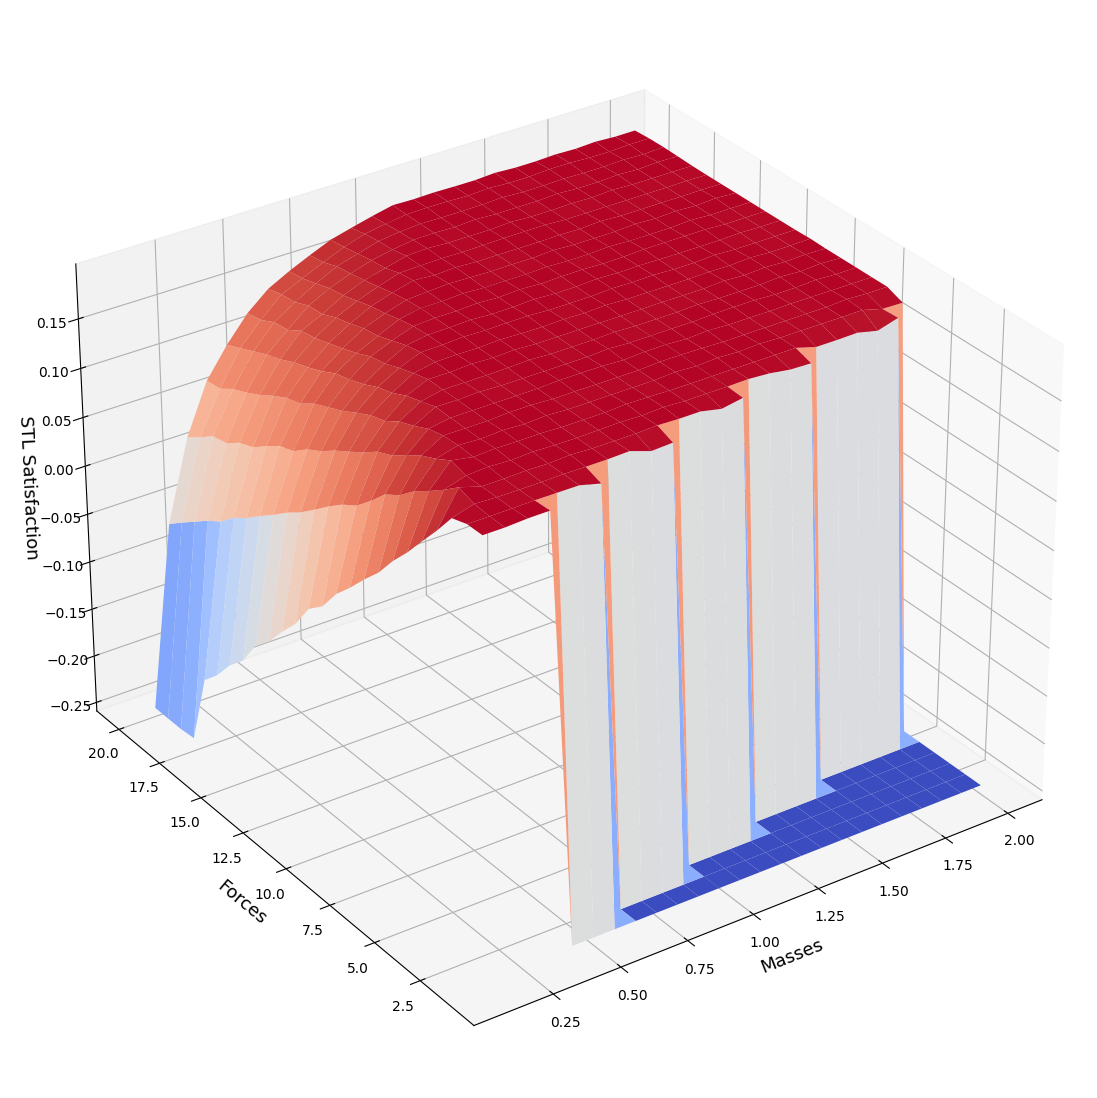

In [17]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces",
                                                   z_name="STL Satisfaction")
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png', bbox_inches='tight')
plt.show()

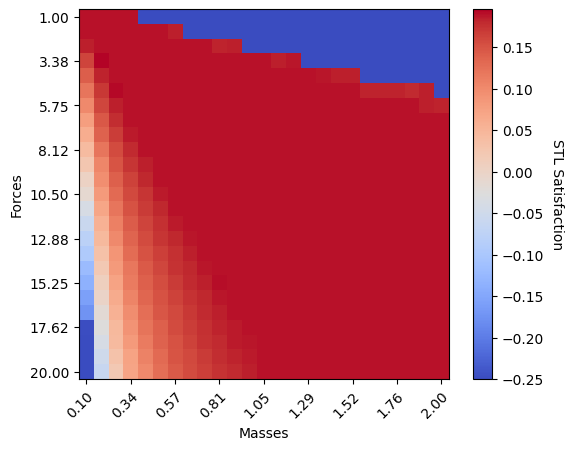

In [18]:
analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction")
plt.savefig('gifs/robustness-landscape-heatmap.png', bbox_inches='tight')
plt.show()

### Approximate robustness boundary

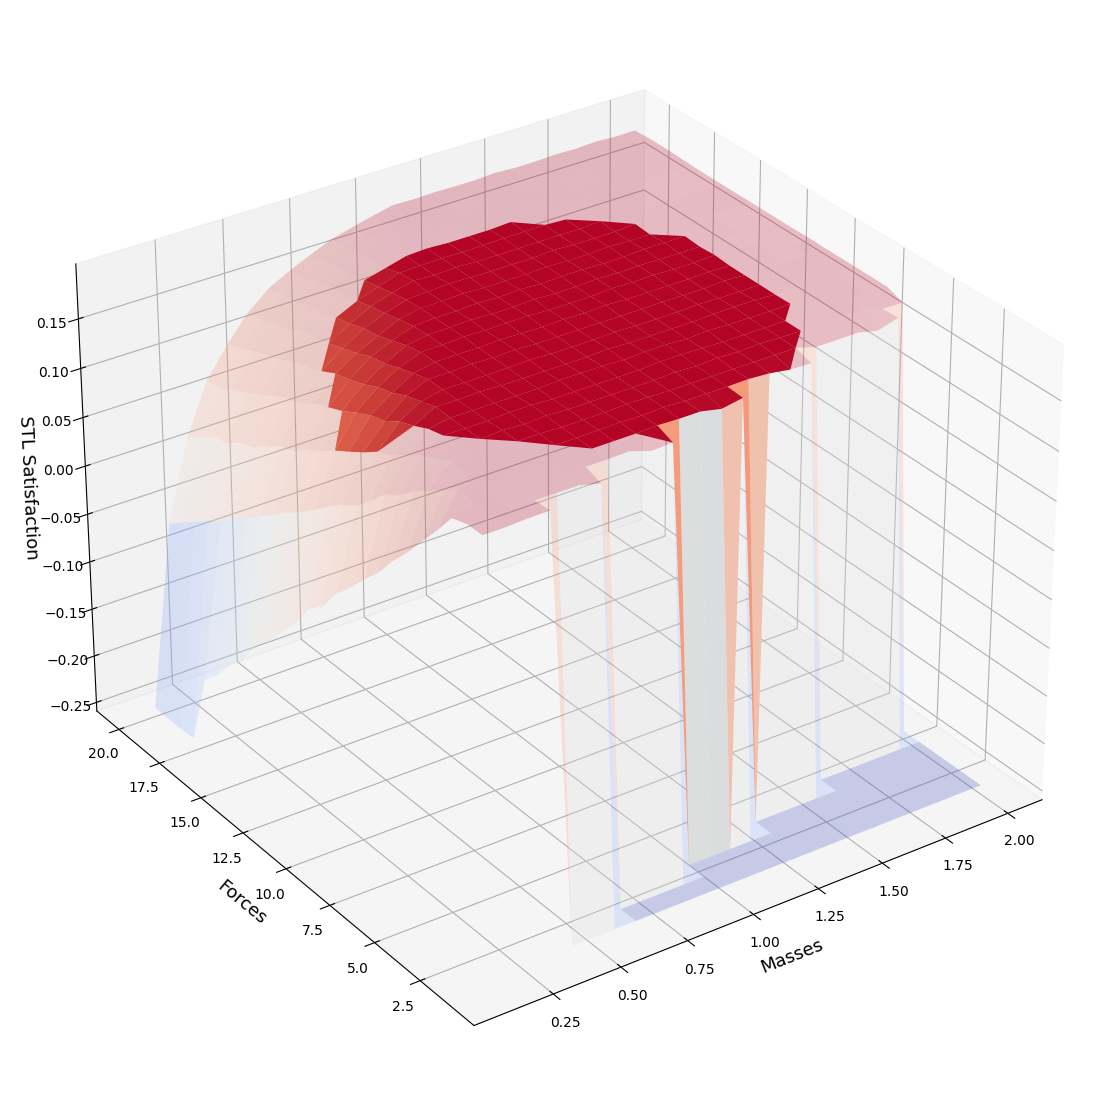

In [19]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces",
                                                   z_name='STL Satisfaction', boundary=boundary)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-boundary.png', bbox_inches='tight')
plt.show()

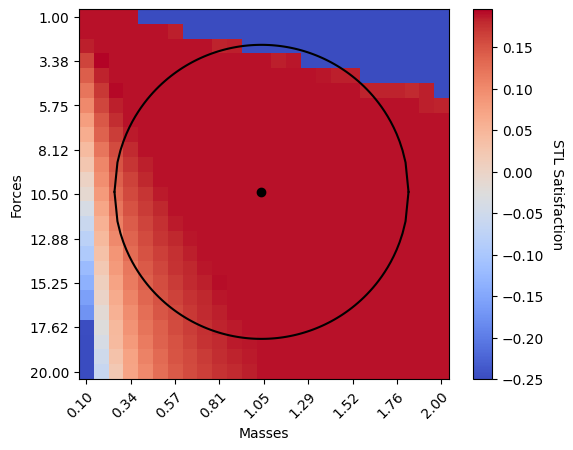

In [20]:
analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction",
                 boundary=boundary)
plt.savefig('gifs/robustness-landscape-boundary-heatmap.png', bbox_inches='tight')
plt.show()

## Analysis with EarlyStop

In [ ]:
analysis2 = EarlyStop(analysis)

In [ ]:
start = datetime.now()
delta, delta_dist, Xss = analysis2.min_unsafe_deviation()
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
plot_convergence(analysis2, Xss)

### Compare performance of baseline and EarlyStop

In [13]:
def run_data(analysis, n=10):
    dists, times = [], []
    for _ in range(n):
        start = datetime.now()
        _, dist, _ = analysis.min_unsafe_deviation()
    
        dists.append(dist)
        times.append(datetime.now() - start)
    return np.array(dists), np.array(times)

In [ ]:
dists1, times1 = run_data(analysis)

In [ ]:
dists2, times2 = run_data(analysis2)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe71ea37a00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe71e6c1f70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe71ea37940>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe71e6c1c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe71f364a90>,
 'means': []}

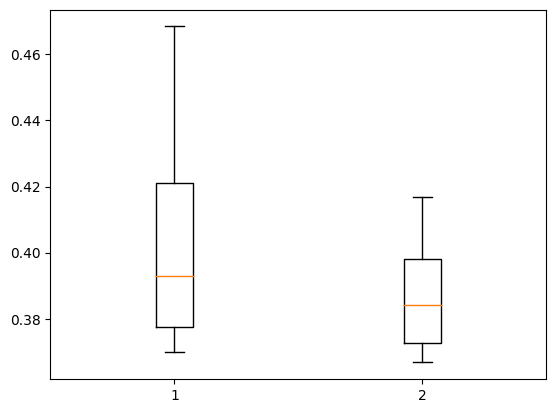

In [21]:
plt.boxplot([dists1, dists2])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe71e7cfd00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe71e55fa60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe71e55f670>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe71e55ffa0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe71e56b280>,
 'means': []}

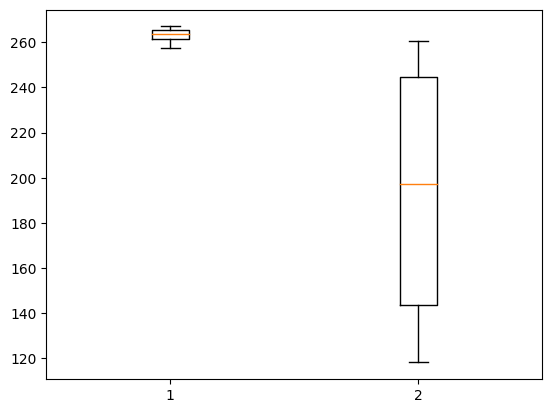

In [22]:
plt.boxplot([[x.total_seconds() for x in times1], [x.total_seconds() for x in times2]])

## Analysis with EarlyStop and MeanOfCMA

In [ ]:
# FIXME: currently the order matters!
analysis3 = EarlyStop(MeanOfCMASamples(analysis))

In [ ]:
start = datetime.now()
delta, delta_dist, Xss = analysis3.min_unsafe_deviation()
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
plot_convergence(analysis3, Xss, 'data_mean_cma')

In [ ]:
## Analysis with EarlyStop and MeanOfRandom

In [ ]:
analysis4 = EarlyStop(MeanOfRandomSamples(analysis))

In [ ]:
start = datetime.now()
delta, delta_dist, Xss = analysis4.min_unsafe_deviation()
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
plot_convergence(analysis4, Xss, 'data_mean_random')

## Use number of violations to evaluate each episode

In [26]:
def episode_eval(obs_record, reward_record):
    pos = normalize(np.abs(obs_record[:, 0]), pos_range)
    angle = normalize(np.abs(obs_record[:, 2]), angle_range)
    
    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)
    
    rob = compute_stl_rob(stl_prop(), signal_builder, obs_record)
    violations = -np.sum((pos >= pos_threshold) | (angle >= angle_threshold))
    return rob + violations / 200

In [27]:
analysis = EarlyStop(RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist))
analysis.options['deviation_restarts'] = 2
analysis.options['deviation_sigma'] = 0.2
analysis.options['deviation_evals'] = 100
analysis.options['falsification_sigma'] = 0.4
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_restarts'] = 0
analysis.options

{'epsilon': 0.01,
 'deviation_restarts': 2,
 'deviation_sigma': 0.2,
 'deviation_timeout': inf,
 'deviation_evals': 100,
 'falsification_sigma': 0.4,
 'falsification_timeout': 1,
 'falsification_restarts': 0,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 200}

In [28]:
start = datetime.now()
delta, delta_dist, Xss = analysis.min_unsafe_deviation()
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

================ Using early stop optimization! =================>

================ Min unsafe deviation trial 1 ==============>
Constraints weight: 1 Boundary: None
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=892663, Tue Nov 29 11:46:44 2022)


/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


=============== CMA Results: =================>
CMAEvolutionStrategyResult(xbest=array([0.68194518, 0.11317509]), fbest=-0.8064064146836807, evals_best=62, evaluations=102, iterations=17, xfavorite=array([0.75042631, 0.01336789]), stds=array([0.47954447, 0.27590058]), stop={'maxfevals': 100})
==============================================>
{'x': array([0.56716099, 0.06944906]), 'f': 0.41490235169592077, 'g': [-0.970000009934107], 'f_al': -0.5762715691141029, 'g_al': [-0.9911739208100236], 'count': 80}

================ Min unsafe deviation trial 2 ==============>
Constraints weight: 1 Boundary: 0.41490235169592077
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=804401, Tue Nov 29 11:48:12 2022)
=============== CMA Results: =================>
CMAEvolutionStrategyResult(xbest=array([0.42274679, 0.03099947]), fbest=0.0009426927988129479, evals_best=38, evaluations=102, iterations=17, xfavorite=array([0.52818988, 0.08910442]), stds=array([0.05372457, 0.03512726]), stop={'maxfevals'

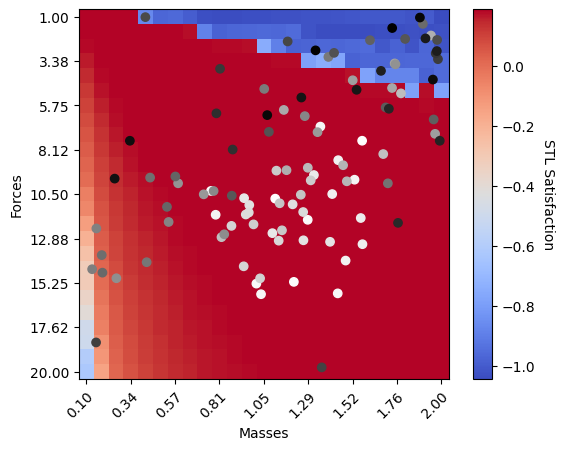

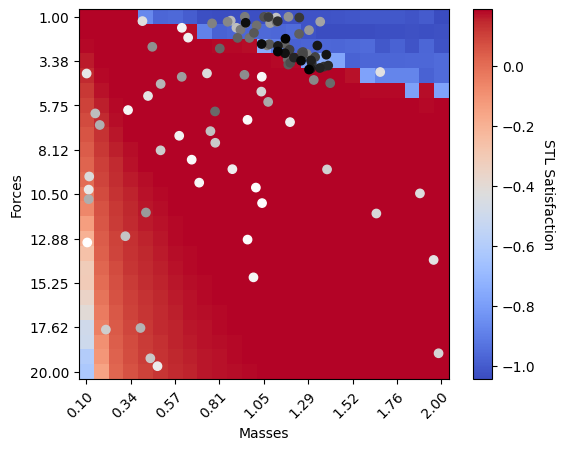

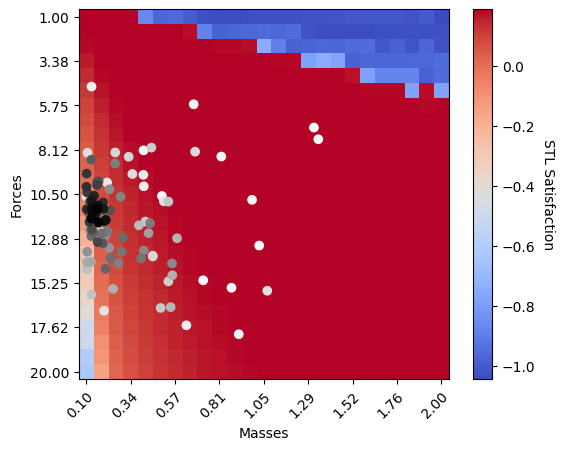

In [29]:
plot_convergence(analysis, Xss, 'data_violation')

### Using reward as the evaluation functionpos_threshold

In [ ]:
# def episode_eval_reward(obs_record, reward_record):
#     return reward_record.sum() - 200

In [ ]:
# analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
# analysis_reward.options['falsification_num_trials'] = 1